In [1]:
# mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install kaggle
!pip install -q kaggle

In [3]:
# configure the kaggle API access
# create a directory for kaggle in the Colab environment
# copy the kaggle.json file from the Google Drive
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [4]:
# set permission to the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# download the dataset using the kaggle API command
!kaggle datasets download tanshihjen/octdl-oct-dataset

Dataset URL: https://www.kaggle.com/datasets/tanshihjen/octdl-oct-dataset
License(s): unknown
100% 380M/380M [00:21<00:00, 18.3MB/s]
100% 380M/380M [00:21<00:00, 18.5MB/s]


In [6]:
# unzip the download dataset
!unzip octdl-oct-dataset.zip

Archive:  octdl-oct-dataset.zip
  inflating: OCTDL/AMD/amd_1047099_1.jpg  
  inflating: OCTDL/AMD/amd_1047099_2.jpg  
  inflating: OCTDL/AMD/amd_1047099_3.jpg  
  inflating: OCTDL/AMD/amd_1047099_4.jpg  
  inflating: OCTDL/AMD/amd_1084498_1.jpg  
  inflating: OCTDL/AMD/amd_1084498_2.jpg  
  inflating: OCTDL/AMD/amd_1084498_3.jpg  
  inflating: OCTDL/AMD/amd_1096590_1.jpg  
  inflating: OCTDL/AMD/amd_1096590_2.jpg  
  inflating: OCTDL/AMD/amd_1096590_3.jpg  
  inflating: OCTDL/AMD/amd_1096590_4.jpg  
  inflating: OCTDL/AMD/amd_1096590_5.jpg  
  inflating: OCTDL/AMD/amd_1101816_1.jpg  
  inflating: OCTDL/AMD/amd_1101816_2.jpg  
  inflating: OCTDL/AMD/amd_1101816_3.jpg  
  inflating: OCTDL/AMD/amd_1101816_4.jpg  
  inflating: OCTDL/AMD/amd_1131743_1.jpg  
  inflating: OCTDL/AMD/amd_1163930_1.jpg  
  inflating: OCTDL/AMD/amd_1163930_2.jpg  
  inflating: OCTDL/AMD/amd_1163930_3.jpg  
  inflating: OCTDL/AMD/amd_1168623_1.jpg  
  inflating: OCTDL/AMD/amd_1168623_2.jpg  
  inflating: OCTDL/AMD

In [7]:
# import essential libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import models, layers

In [8]:
# load the train and validation datasets
train_df = pd.read_csv('/content/drive/MyDrive/dataset/oct_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/dataset/oct_val.csv')

In [9]:
# number of classes in the dataset
print('Number of classes in the dataset:', train_df.Label.nunique())
print('Classes in the dataset:', train_df.Label.unique())

Number of classes in the dataset: 7
Classes in the dataset: ['NO' 'DME' 'RAO' 'VID' 'AMD' 'RVO' 'ERM']


In [10]:
# compute the class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['Label'].unique()), y=train_df['Label'])
class_weights_dict = dict(zip(np.unique(train_df['Label'].unique()), np.round(class_weights,4)))
print(class_weights_dict)

{'AMD': 0.2401, 'DME': 1.9973, 'ERM': 1.9056, 'NO': 0.8992, 'RAO': 11.5397, 'RVO': 2.8454, 'VID': 3.8466}


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function = None,
    rotation_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.0,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
)

val_datagen = ImageDataGenerator(preprocessing_function=None)

In [12]:
# prepare the dataset
train_ds = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = None,
    x_col = 'Path',
    y_col = 'Label',
    class_mode = 'categorical',
    batch_size = 32,
    target_size = (224, 224),
    shuffle = True,
    seed = 122,
)

val_ds = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = None,
    x_col = 'Path',
    y_col = 'Label',
    class_mode = 'categorical',
    batch_size = 32,
    target_size = (224, 224),
    shuffle = False
)

Found 1454 validated image filenames belonging to 7 classes.
Found 203 validated image filenames belonging to 7 classes.


In [13]:
test_df = pd.read_csv('/content/drive/MyDrive/dataset/oct_test.csv')

test_datagen = ImageDataGenerator(preprocessing_function=None)

test_ds = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = None,
    x_col = 'Path',
    y_col = 'Label',
    class_mode = 'categorical',
    batch_size = 32,
    target_size = (224, 224),
    shuffle = False
)

Found 407 validated image filenames belonging to 7 classes.


In [14]:
# define list of callbacks to enhance model training
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/models/oct_enetv2m_sp_cw_151124.keras', save_best_only=True),
    keras.callbacks.CSVLogger(filename='/content/drive/MyDrive/learning_history/oct_enetv2m_sp_cw_151124.csv'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='min', min_lr=0.00001)
    ]

In [15]:
# metrics to be used for compiling the model
metrics = [
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

In [16]:
from keras.applications import EfficientNetV2M

# helper function to define the neural network on top of the pre-trained model
def tf_model():
  input_shape = (224, 224, 3)

  inputs = keras.Input(shape=input_shape)
  x = tf.keras.layers.Rescaling(1./255)(inputs)

  base_model = EfficientNetV2M(
    include_top = False,
    weights = 'imagenet',
    input_shape = input_shape,
    pooling = 'avg'
)

  base_model.trainable = True

  x = base_model(x)

  x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
  x = layers.Dense(units=256, activation='relu')(x)
  x = layers.Dense(units=128, activation='relu')(x)
  x = layers.Dropout(rate=0.25, seed=122)(x)
  output = layers.Dense(units=7, activation='softmax')(x)

  model = keras.models.Model(inputs=inputs, outputs=output)

  model.compile(optimizer = keras.optimizers.Adamax(learning_rate=0.001),
                loss = keras.losses.categorical_crossentropy,
                metrics = metrics
                )

  return model

In [17]:
# create th model
enetv2m_sp_cw_151124 = tf_model()

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [18]:
# fit the model with the training data
history = enetv2m_sp_cw_151124.fit(train_ds,
                                   epochs = 100,
                                   validation_data = val_ds,
                                   callbacks = callbacks,
                                   class_weight = class_weights_dict)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 386s 4s/step - auc: 0.8303 - categorical_accuracy: 0.5579 - loss: 1.4764 - precision: 0.6652 - recall: 0.4356 - val_auc: 0.9680 - val_categorical_accuracy: 0.7980 - val_loss: 0.7689 - val_precision: 0.9802 - val_recall: 0.4877 - learning_rate: 0.0010
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 630ms/step - auc: 0.9445 - categorical_accuracy: 0.7479 - loss: 0.8203 - precision: 0.8428 - recall: 0.6611 - val_auc: 0.9647 - val_categorical_accuracy: 0.8079 - val_loss: 0.8846 - val_precision: 0.9794 - val_recall: 0.4680 - learning_rate: 0.0010
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 39s 778ms/step - auc: 0.9641 - categorical_accuracy: 0.7966 - loss: 0.6366 - precision: 0.8661 - recall: 0.7275 - val_auc: 0.9638 - val_categorical_accuracy: 0.7438 - val_loss: 0.7181 - val_precision: 0.9084 - val_recall: 0.5862 - learning_rate: 0.0010
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 603ms/step - auc: 0.9802 - categorical_accuracy: 0.8397 - loss: 0.4689 - precision: 0.9021 - re

In [19]:
enetv2m_sp_cw_151124.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-m (Functional)        │ (None, 1280)                │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,962,547 (610.21 MB)

 Trainable params: 53,222,651 (203.03 MB)

 Non-trainable params: 294,592 (1.12 MB)

 Optimizer params: 106,445,304 (406.06 MB)

In [20]:
# export the trained model
enetv2m_sp_cw_151124.save('/content/drive/MyDrive/models/enetv2m_sp_cw_151124.h5')

In [21]:
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/models/oct_enetv2m_sp_cw_151124.keras')

In [22]:
# check the model performance on test dataset
res = enetv2m_sp_cw_151124.evaluate(test_ds)
print(round(res[1]*100,2),'%')

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - auc: 0.9862 - categorical_accuracy: 0.8996 - loss: 0.3220 - precision: 0.9259 - recall: 0.8817
90.42 %


In [23]:
res = saved_model.evaluate(test_ds)
print(round(res[1]*100,2),'%')

13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 765ms/step - auc: 0.9862 - categorical_accuracy: 0.8996 - loss: 0.3220 - precision: 0.9259 - recall: 0.8817
90.42 %


In [24]:
# probabilities and predicted class for the test dataset
ypred_proba = enetv2m_sp_cw_151124.predict(test_ds)
ypred = np.argmax(ypred_proba, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step


In [25]:
# classification report
from sklearn.metrics import classification_report

# the actual class label (ytrue)
y = test_ds.classes

# the classes
label_classes = test_ds.class_indices.keys()

report_enet = classification_report(y, ypred, target_names=label_classes)
print(report_enet)

              precision    recall  f1-score   support

         AMD       0.97      0.96      0.97       238
         DME       0.72      0.72      0.72        29
         ERM       0.78      0.93      0.85        30
          NO       0.92      0.88      0.90        68
         RAO       0.75      1.00      0.86         3
         RVO       0.58      0.48      0.52        23
         VID       0.84      1.00      0.91        16

    accuracy                           0.90       407
   macro avg       0.80      0.85      0.82       407
weighted avg       0.90      0.90      0.90       407



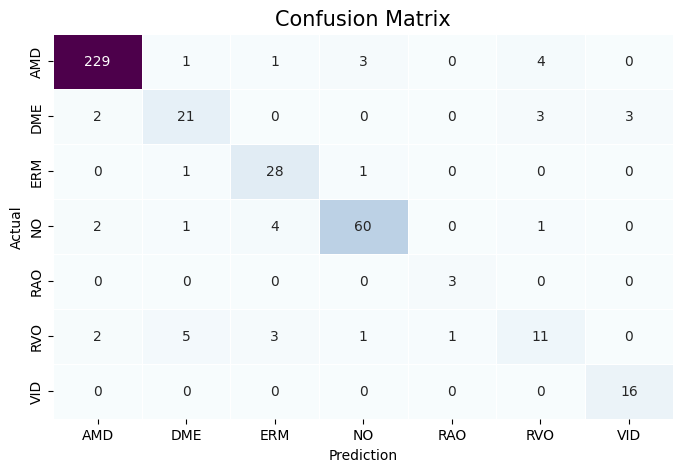

In [26]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, ypred)

# visualize the confusion matrix in heatmap
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt='.4g', cbar=False, cmap='BuPu', xticklabels=label_classes, yticklabels=label_classes, linewidth=0.5)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix', fontsize=15)
plt.show()